In [1]:
# Check package versions
import gammapy
import numpy as np
import astropy
import regions
import matplotlib

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)
print("matplotlib", matplotlib.__version__)

gammapy: 0.19
numpy: 1.21.2
astropy 4.3.1
regions 0.5
matplotlib 3.5.1


In [2]:
%matplotlib inline
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')
from matplotlib.offsetbox import AnchoredText
from pathlib import Path
from regions import CircleSkyRegion

from gammapy.maps import Map, RegionGeom
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    MapDataset,
)
from gammapy.maps import MapAxis, WcsGeom
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions
from gammapy.makers.utils import make_theta_squared_table
from gammapy.visualization import plot_theta_squared_table
from scipy.optimize import curve_fit

In [3]:
location_data = '/home/lavergne/Téléchargements/hess_dl3_dr1/' #path to DL3 folder
source_name = 'Crab' #e.g., Crab, GRB210807A
cut_type = 'loose' #e.g., loose, hard, ...
filename_output = '{name}_{cut}'.format(name=source_name, cut=cut_type)

In [4]:
source_position = SkyCoord.from_name(source_name)
max_offset_run = 2.5 * u.deg

In [5]:
#If not existing create folder to store the images in the current folder
work_directory = os.getcwd()
path_plot = Path(work_directory+"/figures")
path_plot.mkdir(exist_ok=True)

In [6]:
e_min = 0.01 * u.TeV
e_max = 20. * u.TeV
on_radius = 0.2 * u.deg
exclusion_radius = 0.35*u.deg

In [7]:
max_theta_squared = exclusion_radius.to(u.deg).value**2
n_bin_per_square_deg = 120

# Load Data

In [8]:
data_store = DataStore.from_dir(location_data)

In [9]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: /home/lavergne/Téléchargements/hess_dl3_dr1
Rows: 525
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



In [10]:
data_store.obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20275,187.27792,2.552389,289.7155,64.849686,36.18243,53.81757,49.144917,3C 273,187.27792,2.052389,0.5,1683.0,1525.8447,0.90662193,103665036.0,103666719.0,2004-04-14,19:51:40.184,2004-04-14,20:19:43.184,4,"1,2,3,4",0,1.121256,10646,Off data,offdata,--,0.33113113,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47802,330.29538,-30.225555,17.818897,-52.742733,36.828686,53.171314,110.0,PKS 2155-304,329.71667,-30.225555,0.50002956,1688.0,1572.4065,0.9315204,241558291.0,241559979.0,2008-08-27,19:32:35.184,2008-08-27,20:00:43.184,4,"1,2,3,4",0,0.9731573,5998,PKS 2155-304 (steady),pks2155_steady,0.4998021,0.61659503,100.0


In [11]:
#Select all runs automatically, otherwise specify single runs.
#obs_ids = [5543, 5544, 5545]
obs_ids = data_store.obs_table[source_position.separation(data_store.obs_table.pointing_radec) < max_offset_run]['OBS_ID']
obs_collection = data_store.get_observations(obs_ids, required_irf=None)

No HDU found matching: OBS_ID = 23523, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23523, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23526, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23526, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23559, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23559, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23592, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23592, HDU_TYPE = rad_max, HDU_CLASS = None


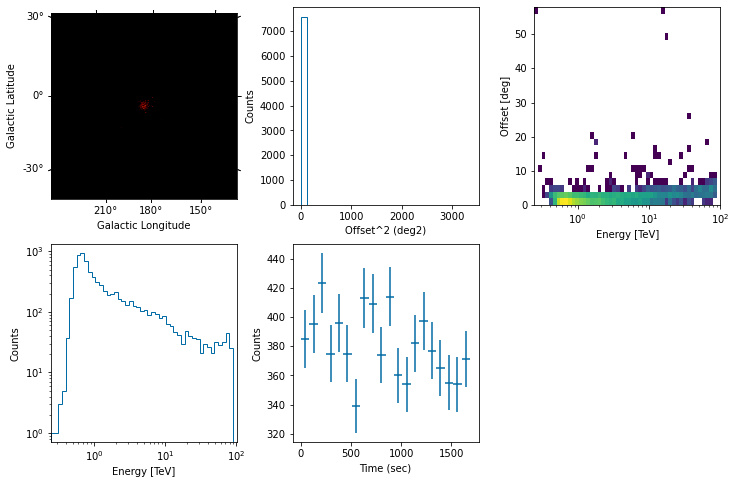

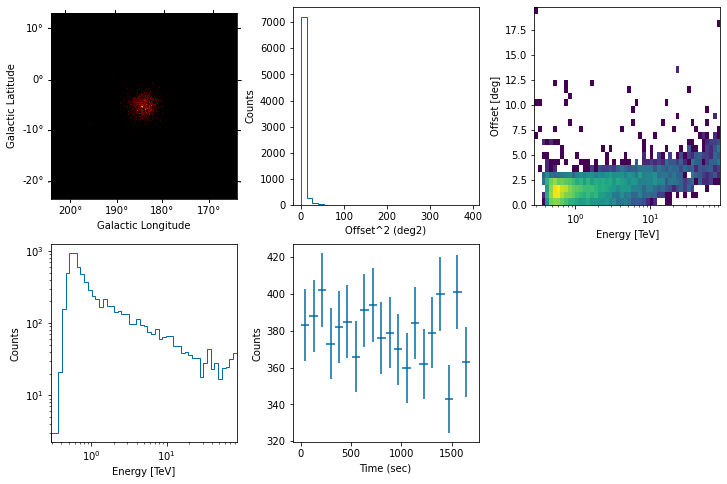

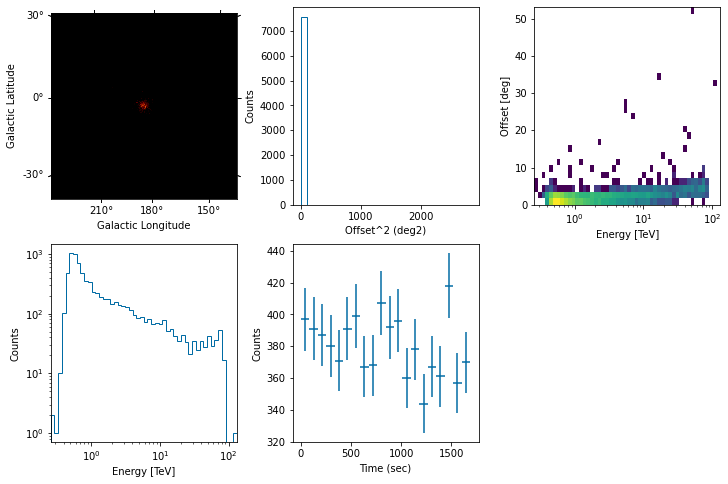

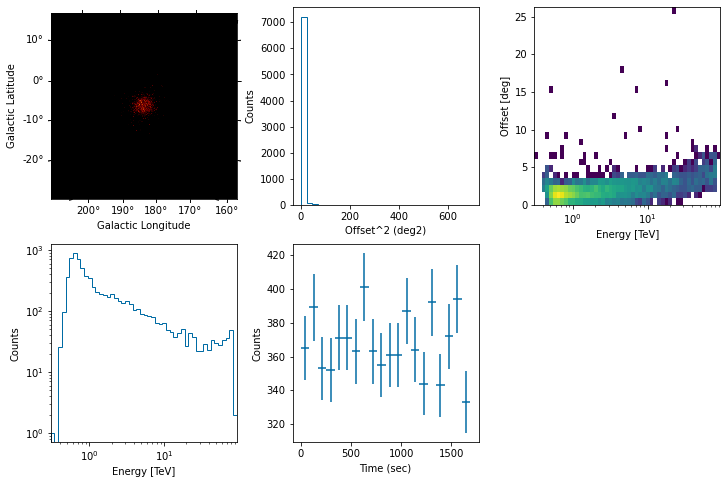

In [12]:
for i in range(len(obs_collection)):
    obs_collection[i].events.peek()

# Define on Region and exclusion region

In [13]:
on_region = CircleSkyRegion(center=source_position, radius=on_radius)
exclude_region = CircleSkyRegion(center=source_position, radius=exclusion_radius)

In [14]:
energy_axis = MapAxis.from_edges(
    np.logspace(np.log10(e_min.to_value(u.TeV)), np.log10(e_max.to_value(u.TeV)), 2), unit="TeV", name="energy", interp="log"
)
geom_on_region = RegionGeom.create(region=on_region, axes=[energy_axis])
geom = WcsGeom.create(
    skydir=source_position, npix=(200, 200), binsz=0.02, frame="icrs", axes=[energy_axis]
)
geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (200, 200, 1)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 4.0 deg x 4.0 deg
	wcs ref    : 83.6 deg, 22.0 deg

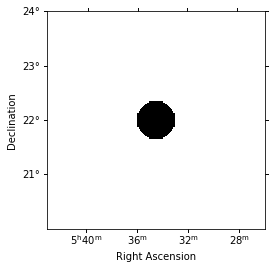

In [15]:
geom_image = geom.to_image()
exclusion_mask = ~geom_image.region_mask([exclude_region])
exclusion_mask.sum_over_axes().plot();

/home/lavergne/software/miniconda3/envs/lst-analysis/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


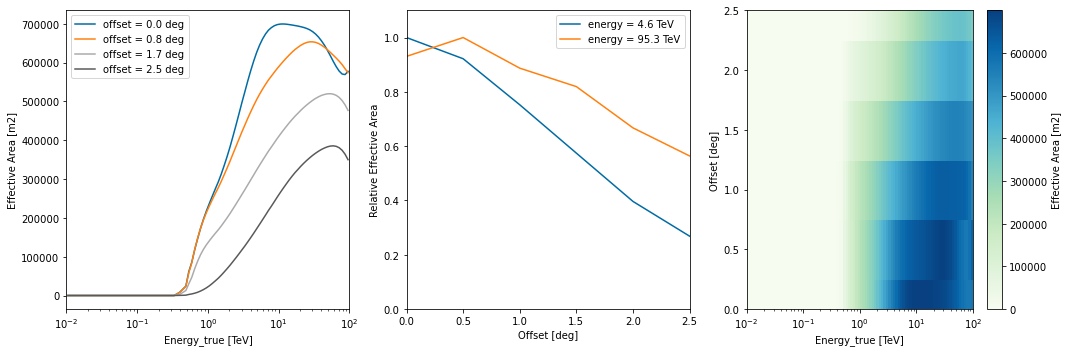

In [16]:
if obs_collection[0].aeff is not None:
    obs_collection[0].aeff.peek()

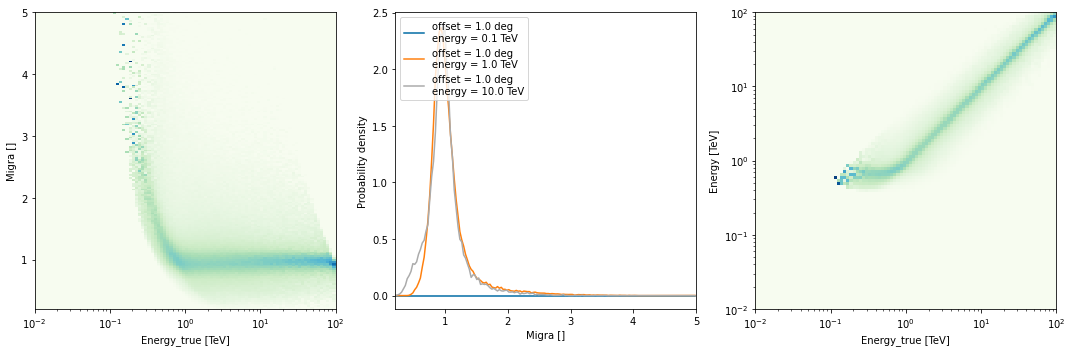

In [17]:
if obs_collection[0].edisp is not None:
    obs_collection[0].edisp.peek()

In [18]:
if obs_collection[0].bkg is not None:
    obs_collection[0].bkg.peek()

# Count Map

In [19]:
stacked = MapDataset.create(geom=geom, name=source_name+'_stacked')
unstacked = Datasets()
maker = MapDatasetMaker(selection=["counts"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max="4 deg")

for obs in obs_collection:
    cutout = stacked.cutout(obs.pointing_radec, width="6.5 deg")
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    stacked.stack(dataset)
    unstacked.append(dataset)

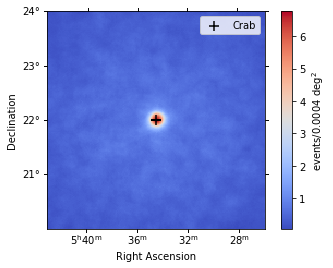

In [20]:
stacked.to_image().counts.smooth('0.12 deg', kernel='disk').plot(add_cbar=True, cmap='coolwarm')
cbar = plt.gca().images[-1].colorbar
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel(r'events/0.0004 deg$^2$', rotation=90)
plt.gca().scatter(source_position.ra, source_position.dec, transform=plt.gca().get_transform('world'), marker='+', c='k', label=source_name, s=100)
plt.legend()

plt.savefig(os.path.join(path_plot,'{}__countmap.png'.format(filename_output)), dpi=300)

# Multiple OFF Significance

In [21]:
dataset_maker_spectrum_significance = SpectrumDatasetMaker(selection=["counts", "exposure"], use_region_center=True)
spectrum_dataset_empty_significance = SpectrumDataset.create(geom=geom_on_region)
bkg_maker_spectrum_significance = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

datasets_significance = Datasets()
for obs in obs_collection:
    dataset_spectrum_significance = dataset_maker_spectrum_significance.run(spectrum_dataset_empty_significance.copy(name=f"obs-{obs.obs_id}"), obs)
    dataset_on_off_spectrum_significance = bkg_maker_spectrum_significance.run(observation=obs, dataset=dataset_spectrum_significance)
    datasets_significance.append(dataset_on_off_spectrum_significance)
    
info_table = datasets_significance.info_table(cumulative=True)

/home/lavergne/software/miniconda3/envs/lst-analysis/lib/python3.8/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


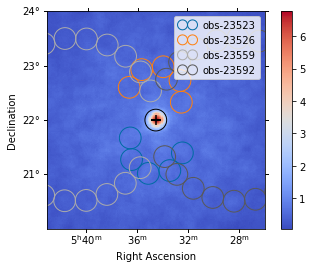

In [22]:
#plt.figure(figsize=(8, 8))
ax = stacked.to_image().counts.smooth('0.12 deg', kernel='disk').plot(add_cbar=True, cmap='coolwarm')
on_region.to_pixel(ax.wcs).plot(ax=ax, color='black')
plot_spectrum_datasets_off_regions(datasets=datasets_significance, ax=ax)
plt.gca().scatter(source_position.ra, source_position.dec, transform=plt.gca().get_transform('world'), marker='+', c='k', label=source_name, s=[100])
plt.show()

In [23]:
print('Livetime :', info_table['livetime'].to('h')[-1])
print('Significance :', info_table['sqrt_ts'][-1])
print('Excess :', info_table['excess'][-1])
print('S/B :', info_table['excess'][-1]/info_table['background'][-1])
print('Rate :',info_table['excess_rate'].to(1./u.min)[-1].value, 'per min')

Livetime : 1.7538365668389533 h
Significance : 40.97981440114184
Excess : 914.9524
S/B : 4.4404902538120385
Rate : 8.69477055690162 per min


In [24]:
theta2_axis = MapAxis.from_bounds(0, max_theta_squared, nbin=int(n_bin_per_square_deg*max_theta_squared), interp="lin", unit="deg2")

theta2_table = make_theta_squared_table(
    observations=obs_collection,
    position=source_position,
    theta_squared_axis=theta2_axis,
)

In [25]:
#Values to be used for the plots
counts_on = theta2_table['counts']
counts_on_err = np.sqrt(counts_on)

counts_off = theta2_table['counts_off']
counts_off_err = np.sqrt(counts_off)

excess = theta2_table['excess']
excess_err = np.append(np.abs(theta2_table['excess_errn'].data[np.newaxis,:]),
                       theta2_table['excess_errp'].data[np.newaxis,:],
                       axis=0)

bin_center = theta2_axis.center
theta2_cut = on_radius.to_value(u.deg)**2

In [26]:
#Definition of extra test in theta2 plot
N_off_err = np.sqrt(info_table['counts_off'][-1])
significance_lima = info_table['sqrt_ts'][-1]

text = r'Livetime = {:.1f}'\
        f'\n'\
        r'N$_{{\rm on}}$ = {:.0f}'\
        f'\n'\
        r'1/$\alpha$ = {:.1f}'\
        f'\n'\
        r'N$_{{\rm off}}$ = {:.1f} $\pm$ {:.1f}'\
        f'\n'\
        r'N_excess = {:.1f}'\
        f'\n'\
        r'Significance (Li&Ma) = {:.1f} $\sigma$ '.format(info_table['livetime'].to('h')[-1],
                                                          info_table['counts'][-1],
                                                          1/info_table['alpha'][-1],
                                                          info_table['counts_off'][-1],
                                                          N_off_err,
                                                          info_table['excess'][-1],
                                                          significance_lima)

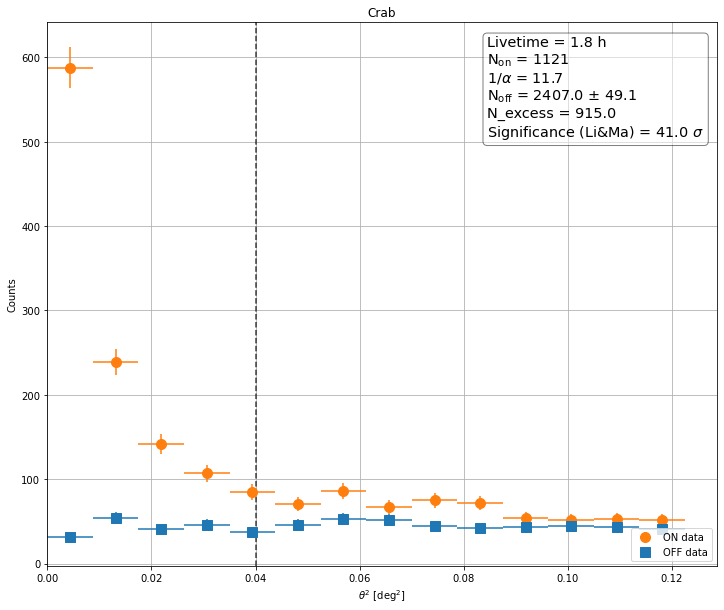

In [27]:
#Theta2 plot
fig, ax = plt.subplots(figsize=(12, 10))

ax.errorbar(bin_center, counts_on, xerr=theta2_axis.bin_width/2, yerr=counts_on_err, fmt='o', label='ON data', ms=10, color='tab:orange')
ax.errorbar(bin_center, counts_off, xerr=theta2_axis.bin_width/2, yerr=counts_off_err,fmt='s',label='OFF data', ms=10, color='tab:blue')
ax.set_xlim(left=0)
ax.grid(ls='-')
ax.axvline(theta2_cut, color='black',ls='--',alpha=0.75)
ax.set_xlabel("$\\theta^2$ [deg$^2$]")
ax.set_ylabel("Counts")
ax.legend(loc='lower right')
ax.set_title(source_name)

box_prop = dict(boxstyle='Round', facecolor='white', alpha=0.5)
text_prop = dict(fontsize='x-large', bbox=box_prop)
txt = AnchoredText(text, loc=1, transform=ax.transAxes, prop=text_prop, frameon=False)
ax.add_artist(txt)

plt.savefig(os.path.join(path_plot,'{}_theta2.png'.format(filename_output)), dpi=300)

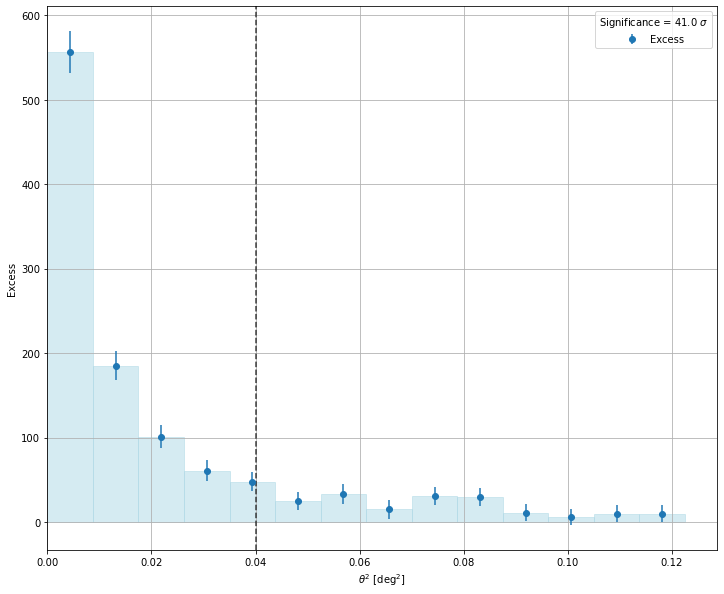

In [28]:
#Excess plot
fig, ax = plt.subplots(figsize=(12, 10))

ax.errorbar(bin_center, excess, yerr=excess_err,fmt='o',color='tab:blue',label='Excess')
ax.bar(bin_center, excess, theta2_axis.bin_width.to_value(u.deg**2), color='lightblue', ec='lightblue', alpha=0.5)
#ax.axhline(0)
ax.set_xlim(left=0)
ax.axvline(theta2_cut, color='black', ls='--', alpha=0.75)
ax.grid(ls='-')
ax.set_xlabel("$\\theta^2$ [deg$^2$]")
ax.set_ylabel("Excess")
ax.legend(loc='upper right', title=f'Significance = {significance_lima:.1f} $\sigma$')

plt.savefig(os.path.join(path_plot,'{}_theta2_excess.png'.format(filename_output)), dpi=300)

In [29]:
excess_err_livetime = np.sqrt(np.sqrt(info_table['counts'])**2+(np.sqrt(info_table['counts_off'])*info_table['alpha'])**2)

excess_livetime_function = lambda x, a: a*x
significance_livetime_function = lambda x, a: a*np.sqrt(x)

popt_excess_livetime, pcov_excess_livetime = curve_fit(excess_livetime_function,
                                                       info_table['livetime'].to(u.h), 
                                                       info_table['excess'], 
                                                       sigma=excess_err_livetime)
popt_significance_livetime, pcov_significance_livetime = curve_fit(significance_livetime_function,
                                                                   info_table['livetime'].to(u.h), 
                                                                   info_table['sqrt_ts'])

popt_excess_livetime = popt_excess_livetime[0]*u.Unit('h^-1')
pcov_excess_livetime = pcov_excess_livetime[0, 0]*u.Unit('h^-2')
popt_significance_livetime = popt_significance_livetime[0]*u.Unit('h^(-1/2)')
pcov_significance_livetime = pcov_significance_livetime[0, 0]*u.Unit('h^(-1)')

In [30]:
x_plot_livetime = np.linspace(0, np.max(info_table['livetime'].to(u.h))*1.2, num=len(info_table['livetime'])*10)

y_plot_fit_excess_livetime = excess_livetime_function(x_plot_livetime, popt_excess_livetime)
y_err_plot_fit_excess_livetime = x_plot_livetime*np.sqrt(pcov_excess_livetime)

y_plot_fit_significance_livetime = significance_livetime_function(x_plot_livetime, popt_significance_livetime)
y_err_plot_fit_significance_livetime = np.sqrt(x_plot_livetime)*np.sqrt(pcov_significance_livetime)

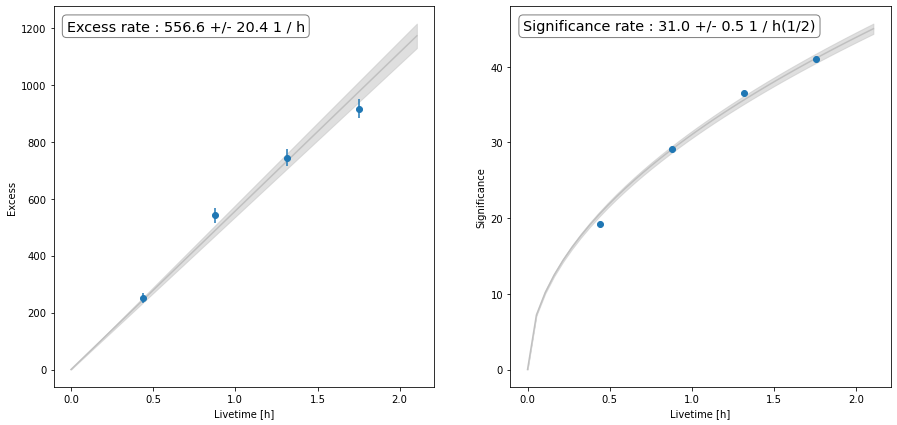

In [31]:
fig, ax = plt.subplots(figsize=(15, 7), ncols=2)
ax1, ax2 = ax[0], ax[1]
ax1.fill_between(x_plot_livetime.to_value(u.h), 
                 y_plot_fit_excess_livetime-y_err_plot_fit_excess_livetime,
                 y_plot_fit_excess_livetime+y_err_plot_fit_excess_livetime,
                 color='silver', 
                 alpha=0.5)
ax1.plot(x_plot_livetime, y_plot_fit_excess_livetime, c='silver')
ax1.errorbar(info_table['livetime'].to(u.h), info_table['excess'], yerr=excess_err_livetime,fmt='o',color='tab:blue',label='Excess')
ax1.set_xlabel("Livetime [h]")
ax1.set_ylabel("Excess")
txt_ax1 = AnchoredText('Excess rate : {:.1f} +/- {:.1f} '.format(popt_excess_livetime.value, np.sqrt(pcov_excess_livetime).value)+str(popt_excess_livetime.unit), 
                       loc=2, transform=ax1.transAxes, prop=text_prop, frameon=False)
ax1.add_artist(txt_ax1)

ax2.fill_between(x_plot_livetime.to_value(u.h), 
                 y_plot_fit_significance_livetime-y_err_plot_fit_significance_livetime,
                 y_plot_fit_significance_livetime+y_err_plot_fit_significance_livetime,
                 color='silver', 
                 alpha=0.5)
ax2.plot(x_plot_livetime, y_plot_fit_significance_livetime, c='silver')
ax2.errorbar(info_table['livetime'].to(u.h), info_table['sqrt_ts'],fmt='o',color='tab:blue',label='Excess')
txt_ax2 = AnchoredText('Significance rate : {:.1f} +/- {:.1f} '.format(popt_significance_livetime.value, np.sqrt(pcov_significance_livetime).value)+str(popt_significance_livetime.unit), 
                       loc=2, transform=ax2.transAxes, prop=text_prop, frameon=False)
ax2.add_artist(txt_ax2)
ax2.set_xlabel("Livetime [h]")
ax2.set_ylabel("Significance")

plt.savefig(os.path.join(path_plot,'{}__excess_significance_over_time.png'.format(filename_output)), dpi=300)